### Задача

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

##### Наименование файлов с данными

* course_project_train.csv - обучающий датасет
* course_project_test.csv - тестовый датасет

##### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

 ##### Метрика качества

F1-score (sklearn.metrics.f1_score)

##### Требования к решению

**Целевая метрика

F1( β  = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
import catboost as catb

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = 'course_project\course_project_train.csv'
TEST_DATASET_PATH = 'course_project\course_project_test.csv'

**Определение функций**

***Для оценки качества***

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

***Для обработки данных***

In [5]:
def cor_data (df):
    
    # Числовые
    
    # Annual Income
    df.loc[df['Annual Income'].isnull() |
          (df['Annual Income']< df['Monthly Debt'] * 30) |
          (df['Annual Income']>df['Monthly Debt'] * 130), 'Annual Income'] = df['Monthly Debt'] * 71
    
    df['Annual_Income_nan'] = 0
    df.loc[df['Annual Income'].isna(), 'Annual_Income_nan'] = 1
    
    #Tax Liens
    df.loc[df['Tax Liens'].isnull() & 
          (df['Number of Credit Problems'] == 0), 'Tax Liens'] = 0
    df.loc[df['Tax Liens'].isnull() & 
          (df['Number of Credit Problems'] > 0), 'Tax Liens'] = 1
    
    df['Tax_Liens_nan'] = 0
    df.loc[df['Tax Liens'].isna(), 'Tax_Liens_nan'] = 1
    
    # Number of Open Accounts
    df.loc[(df['Number of Open Accounts'].isnull()) |
           (df['Number of Open Accounts']< 1) |
           (df['Number of Open Accounts'] < 26),
            'Number of Open Accounts']= int(df['Number of Open Accounts'].median())
    
    df['Number_of_Open_Accounts_nan'] = 0
    df.loc[df['Number of Open Accounts'].isna(), 'Number_of_Open_Accounts_nan'] = 1
    
    # Years of Credit History 
    df.loc[(df['Years of Credit History'].isnull()) |
            (df['Years of Credit History']> 60), 
            'Years of Credit History'] = df['Years of Credit History'].median()
      
    df['Years_of_Credit_History_nan'] = 0
    df.loc[df['Years of Credit History'].isna(), 'Years_of_Credit_History_nan'] = 1
        
    # Maximum Open Credit
    df.loc[(df['Maximum Open Credit'].isnull()) |
            (df['Maximum Open Credit']< 10000), 
            'Maximum Open Credit'] = df['Maximum Open Credit'].median()
    
    df['Maximum_Open_Credit_nan'] = 0
    df.loc[df['Maximum Open Credit'].isna(), 'Maximum_Open_Credit_nan'] = 1
    
    # Number of Credit Problems
    df.loc[df['Number of Credit Problems'].isnull() |
            (df['Number of Credit Problems'] < 0),
            'Number of Credit Problems'] = 0
    
    df['Number_of_Credit_Problems_nan'] = 0
    df.loc[df['Number of Credit Problems'].isna(), 'Number_of_Credit_Problems_nan'] = 1
    
    # Months since last delinquent
    df.loc[df['Months since last delinquent']>12, 'Months since last delinquent'] = 100  
    df['Months since last delinquent'] = df['Months since last delinquent'].astype(str) 
    df.loc[df['Months since last delinquent']=='100', 'Months since last delinquent'] = 'more 1 year'    
    
    # Bankruptcies
    df.loc[df['Bankruptcies'].isnull() & 
          (df['Number of Credit Problems'] == 0), 'Bankruptcies'] = 0
    df.loc[df['Bankruptcies'].isnull() & 
          (df['Number of Credit Problems'] > 0), 'Bankruptcies'] = 1
    
    df['Bankruptcies_nan'] = 0
    df.loc[df['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1
    
    #  Current Loan Amount 
    df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].median()
      
    df['Current_Loan_Amount_nan'] = 0
    df.loc[df['Current Loan Amount'].isna(), 'Current_Loan_Amount_nan'] = 1
    
    # Current Credit Balance  
    df.loc[df['Current Credit Balance'].isnull(), 'Current Credit Balance'] = df['Current Credit Balance'].median()
      
    df['Current_Credit_Balance_nan'] = 0
    df.loc[df['Current Credit Balance'].isna(), 'Current_Credit_Balance_nan'] = 1        
            
    # Credit Score
    df.loc[df['Credit Score']> 1000, 'Credit Score'] = df['Credit Score'] /10
    df.loc[(df['Credit Score']<500) |
            df['Credit Score'].isnull(),
            'Credit Score'] =  df['Credit Score'].median()
    
    df['Credit_Score_nan'] = 0
    df.loc[df['Credit Score'].isna(), 'Credit_Score_nan'] = 1
    
    #Категориальные
    
    # Home Ownership 
    df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    df.loc[df['Home Ownership'].isnull(), 'Home Ownership'] = df['Home Ownership'].mode()
    
    # Years in current job
    df.loc[df['Years in current job'].isnull(),
            'Years in current job'] = df['Years in current job'].mode()
        
    df['Years_in_current_job_nan'] = 0
    df.loc[df['Years in current job'].isna(), 'Years_in_current_job_nan'] = 1
    
    # Purpose
    df.loc[(df['Purpose'] == 'home improvements') |
           (df['Purpose'] == 'major purchase') |
           (df['Purpose'] == 'wedding') | 
           (df['Purpose'] == 'moving') |
           (df['Purpose'] == 'educational expenses') |
           (df['Purpose'] == 'vacation') |
           (df['Purpose'] == 'renewable energy'), 'Purpose'] = 'other'
    df.loc[df['Purpose'] == 'small business', 'Purpose'] ='business loan'
    
    return df

**Загрузка данных, обзор датасета и целевой переменной**

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### **Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [7]:
df_train.shape

(7500, 17)

In [8]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
df_num = df_train.select_dtypes(include=['int64','float64'])

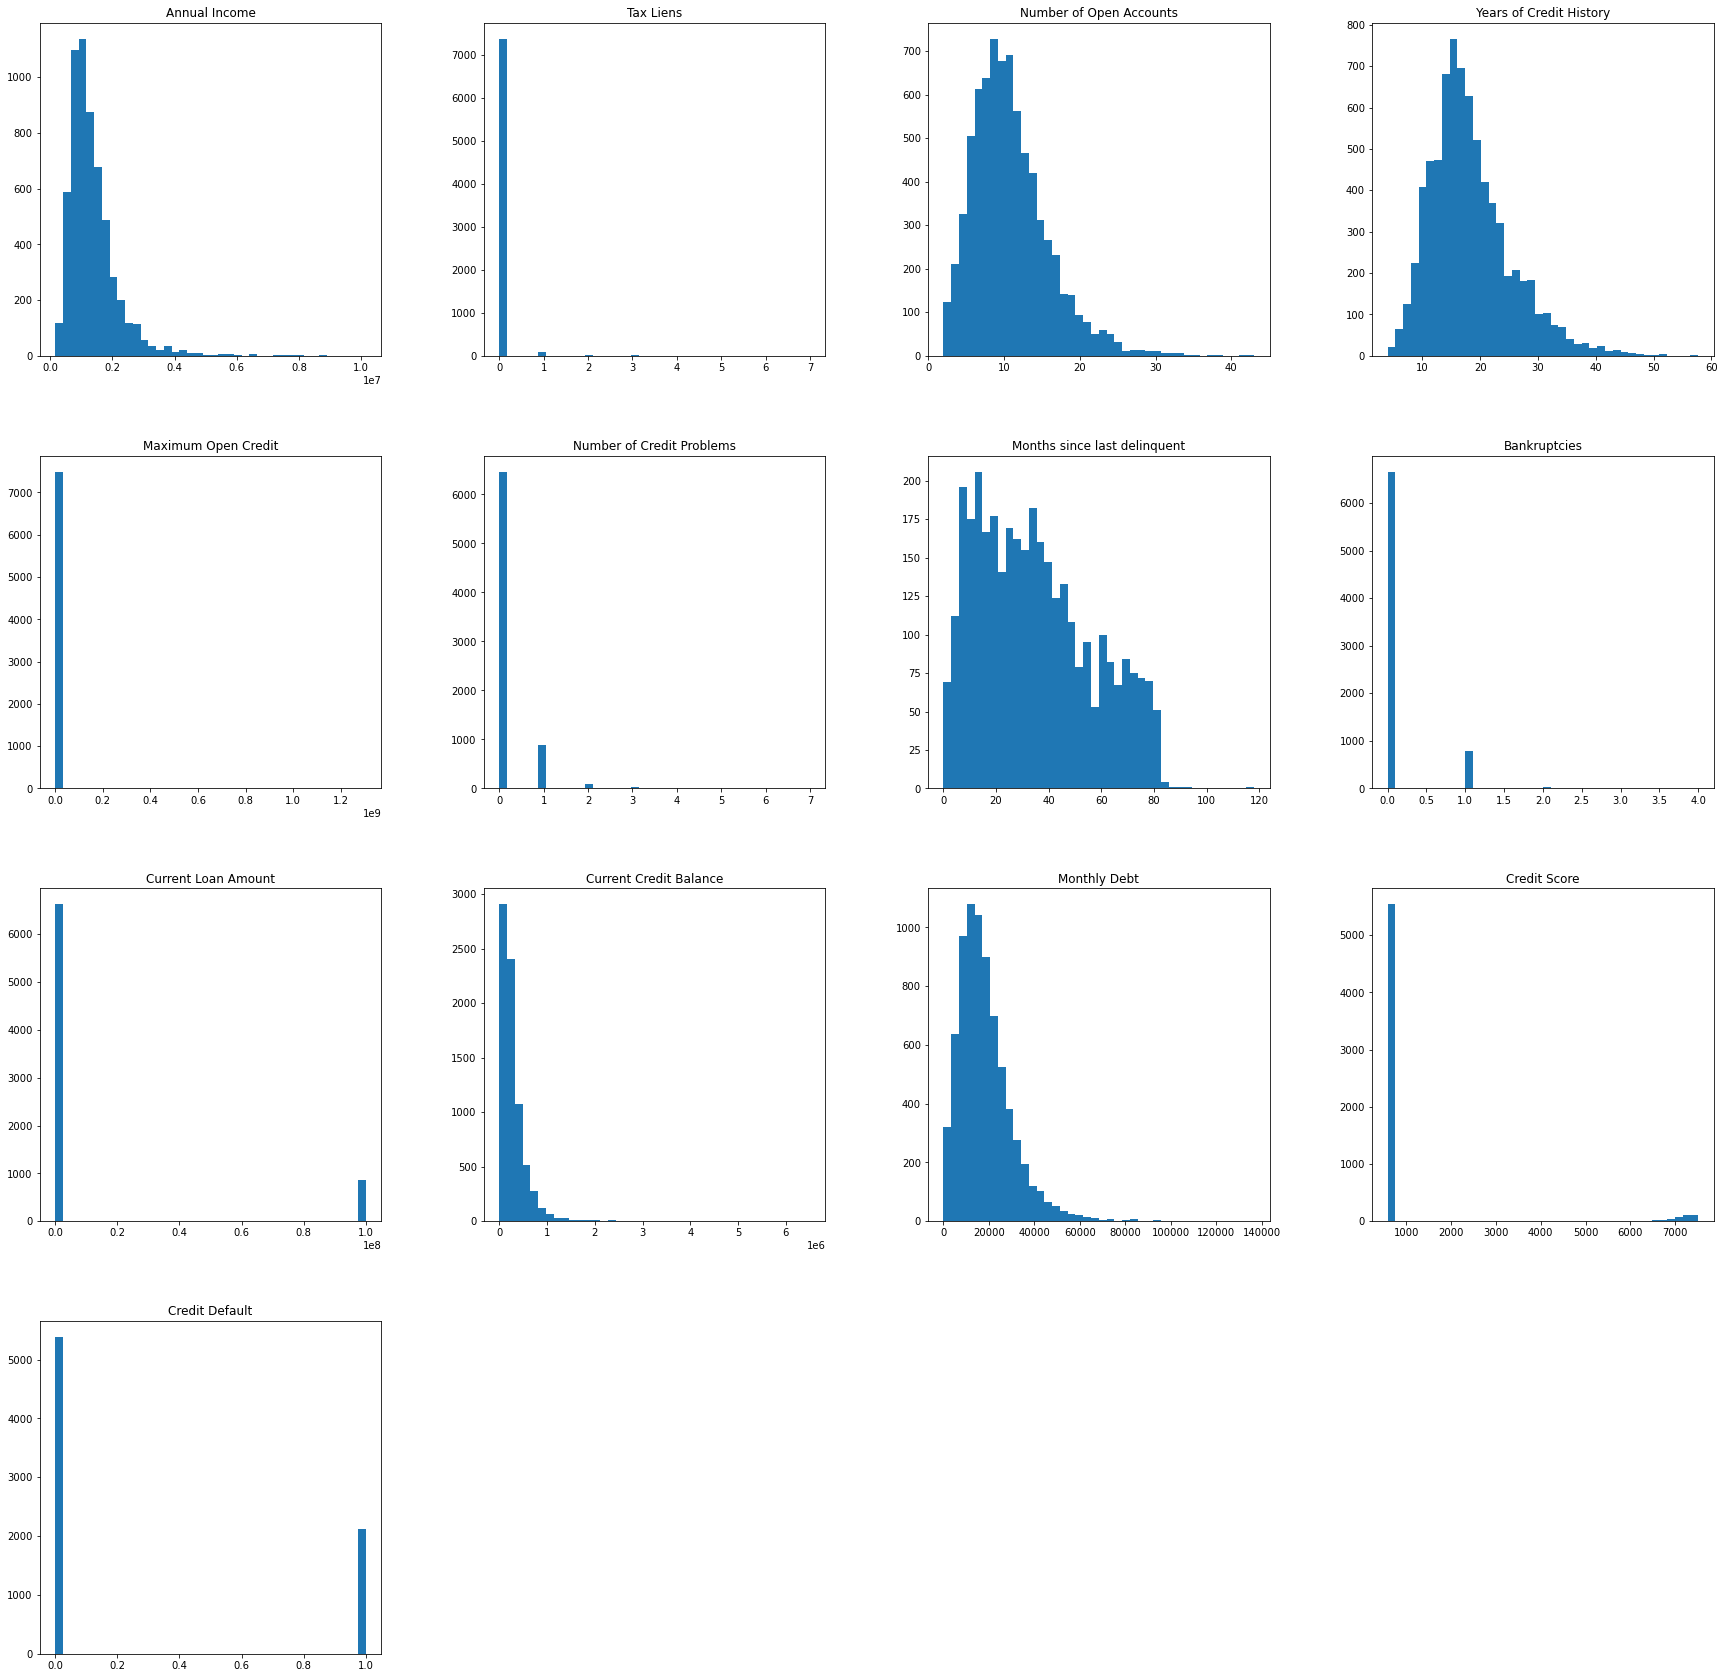

In [11]:
df_num.hist(figsize=(30,30), bins=40, grid=False);

In [12]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [13]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

* **debt consolidation**      5944    консолидация долга  
* **other**                    665    другие
* **home improvements**        412    благоустройство дома 
* **business loan**            129    бизнес-кредит
* **buy a car**                 96    купить машину
* **medical bills**             71    медицинские счета
* **major purchase**            40    крупная покупка
* **take a trip**               37    отправиться в путешествие
* **buy house**                 34    купить дом
* **small business**            26    малый бизнес
* **wedding**                   15    свадьба
* **moving**                    11    переезд
* **educational expenses**      10    расходы на образование
* **vacation**                   8    отпуск
* **renewable energy**           2    возобновляемая энергия

In [14]:
df_train['Months since last delinquent'].value_counts().sort_index()

0.0      18
1.0      26
2.0      25
3.0      30
4.0      31
         ..
84.0      1
86.0      1
91.0      1
92.0      1
118.0     1
Name: Months since last delinquent, Length: 89, dtype: int64

In [15]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

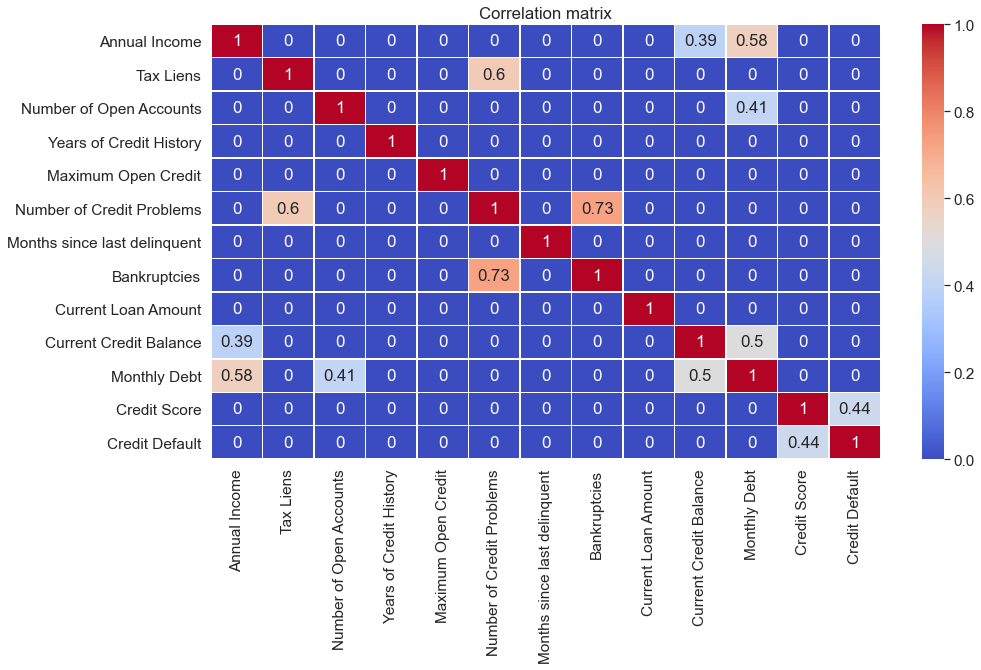

In [16]:
plt.figure(figsize = (15, 8))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

<Figure size 288x288 with 0 Axes>

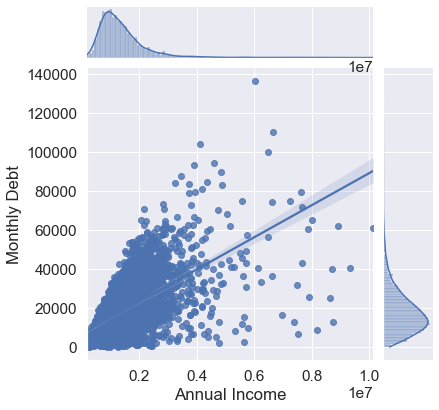

In [17]:
plt.figure(figsize = (4, 4))

grid = sns.jointplot(df_train['Annual Income'], df_train['Monthly Debt'], kind='reg')
plt.show()

**Обработка выбросов и пропусков**

In [18]:
cor_data(df_train)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Tax_Liens_nan,Number_of_Open_Accounts_nan,Years_of_Credit_History_nan,Maximum_Open_Credit_nan,Number_of_Credit_Problems_nan,Bankruptcies_nan,Current_Loan_Amount_nan,Current_Credit_Balance_nan,Credit_Score_nan,Years_in_current_job_nan
0,Own Home,482087.0,10+ years,0.0,10.0,26.3,685960.0,1.0,nan,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,10.0,15.3,1181730.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,10.0,35.0,1182434.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,10.0,22.5,147400.0,1.0,nan,1.0,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,10.0,13.6,385836.0,1.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,134900.0,< 1 year,0.0,10.0,8.5,107866.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7497,Rent,886009.0,6 years,0.0,10.0,32.1,1778920.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
7498,Home Mortgage,2635378.0,NaN,0.0,10.0,26.5,1141250.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 63 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Home Ownership                      7500 non-null   object 
 1   Annual Income                       7500 non-null   float64
 2   Years in current job                7130 non-null   object 
 3   Tax Liens                           7500 non-null   float64
 4   Number of Open Accounts             7500 non-null   float64
 5   Years of Credit History             7500 non-null   float64
 6   Maximum Open Credit                 7500 non-null   float64
 7   Number of Credit Problems           7500 non-null   float64
 8   Months since last delinquent        7500 non-null   object 
 9   Bankruptcies                        7500 non-null   float64
 10  Purpose                             7500 non-null   object 
 11  Term                                7500 no

In [21]:
df_train = df_train.select_dtypes(include=['int64','float64', 'uint8'])

In [22]:
X = df_train.drop(columns = ['Credit Default'])
y = df_train['Credit Default']

**Балансировка целевой переменной**

In [23]:
smote = SMOTE()

# fit predictor and target variable
X_ros, y_ros = smote.fit_resample(X, y)

print('Original dataset shape', len(y))
print('Resample dataset shape', len(y_ros))

Original dataset shape 7500
Resample dataset shape 10774


**Разбиение данных, стандартизация признаков**

In [24]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X_ros, y_ros, shuffle=True, test_size=0.3, random_state=18)

In [25]:
scaler = StandardScaler()

In [26]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

In [27]:
X_test_scaled = scaler.fit_transform(X_test_valid)
X_test_scaled = pd.DataFrame(X_test_scaled)

**Построение модели, обучение, оценка**

In [28]:
model_catb = catb.CatBoostClassifier(n_estimators=1000, max_depth=7, silent=True, random_state=21)
model_catb.fit(X_train_scaled, y_train)

y_train_pred = model_catb.predict(X_train_scaled)
y_test_pred = model_catb.predict(X_test_scaled)

get_classification_report(y_train, y_train_pred, y_test_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      3803
           1       0.97      0.87      0.92      3738

    accuracy                           0.92      7541
   macro avg       0.93      0.92      0.92      7541
weighted avg       0.93      0.92      0.92      7541

TEST

              precision    recall  f1-score   support

           0       0.73      0.82      0.78      1584
           1       0.81      0.71      0.76      1649

    accuracy                           0.77      3233
   macro avg       0.77      0.77      0.77      3233
weighted avg       0.77      0.77      0.77      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1304   280
1                474  1175


**Формирование предсказания по тестовой выборке**

In [29]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [31]:
df_test['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

In [32]:
cor_data(df_test)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Tax_Liens_nan,Number_of_Open_Accounts_nan,Years_of_Credit_History_nan,Maximum_Open_Credit_nan,Number_of_Credit_Problems_nan,Bankruptcies_nan,Current_Loan_Amount_nan,Current_Credit_Balance_nan,Credit_Score_nan,Years_in_current_job_nan
0,Rent,483723.0,4 years,0.0,10.0,12.5,220968.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Rent,231838.0,1 year,0.0,10.0,32.7,55946.0,0.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Home Mortgage,1220313.0,10+ years,0.0,10.0,17.0,456302.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Home Mortgage,2340952.0,6 years,0.0,10.0,23.6,1207272.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,10.0,29.1,559152.0,1.0,100.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2496,Home Mortgage,2342716.0,2 years,0.0,10.0,17.0,1737780.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0
2498,Rent,723520.0,10+ years,0.0,10.0,28.8,945780.0,0.0,nan,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
for cat_colname in df_test.select_dtypes(include='object').columns[1:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [34]:
df_test = df_test.select_dtypes(include=['int64','float64', 'uint8'])

In [35]:
X_test_real = scaler.fit_transform(df_test)

In [36]:
df_test['Credit Default'] = model_catb.predict(X_test_real)

In [37]:
pred_df = pd.DataFrame()
pred_df["Credit Default"] = df_test['Credit Default']

pred_df.to_csv("./MNLukianova_predictions.csv", index=False)